In [2]:

import os
base_dir = "/kaggle/input/rockpaperscissors"
paper_dir=os.path.join(base_dir, "paper")
rock_dir=os.path.join(base_dir, "rock")
scissors_dir=os.path.join(base_dir, "scissors")


In [3]:
print("Rock : ", len(os.listdir(rock_dir)))
print("Paper : ", len(os.listdir(paper_dir)))
print("Scissors : ", len(os.listdir(scissors_dir)))


Rock :  726
Paper :  712
Scissors :  750


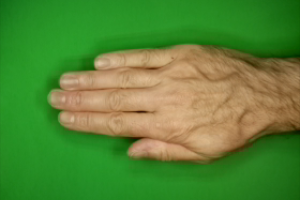

In [4]:
import random
import tensorflow as tf
random_image = random.sample(os.listdir(paper_dir),1)
img=tf.keras.utils.load_img(f"{paper_dir}/{random_image[0]}")
img

In [5]:
img=tf.keras.utils.img_to_array(img)
img.shape

(200, 300, 3)

In [6]:

# İzin verilen sınıflar
allowed_classes = ['rock', 'paper', 'scissors']

# Veri kümesini yalnızca izin verilen sınıflarla oluştur
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="training",
    image_size=(180, 180),
    batch_size=32,
    seed=42,
    class_names=allowed_classes  # Sadece bu sınıfları dahil et
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="validation",
    image_size=(180, 180),
    batch_size=32,
    seed=42,
    class_names=allowed_classes  # Sadece bu sınıfları dahil et
)

# Dahil edilen sınıfları kontrol et
print(f"Yüklenen sınıflar: {train_ds.class_names}")

Found 2188 files belonging to 3 classes.
Using 1751 files for training.
Found 2188 files belonging to 3 classes.
Using 437 files for validation.
Yüklenen sınıflar: ['rock', 'paper', 'scissors']


In [7]:
for image_batch, label_batch in train_ds:
    print(image_batch.shape)
    print(label_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [8]:
class_names=train_ds.class_names
class_names

['rock', 'paper', 'scissors']

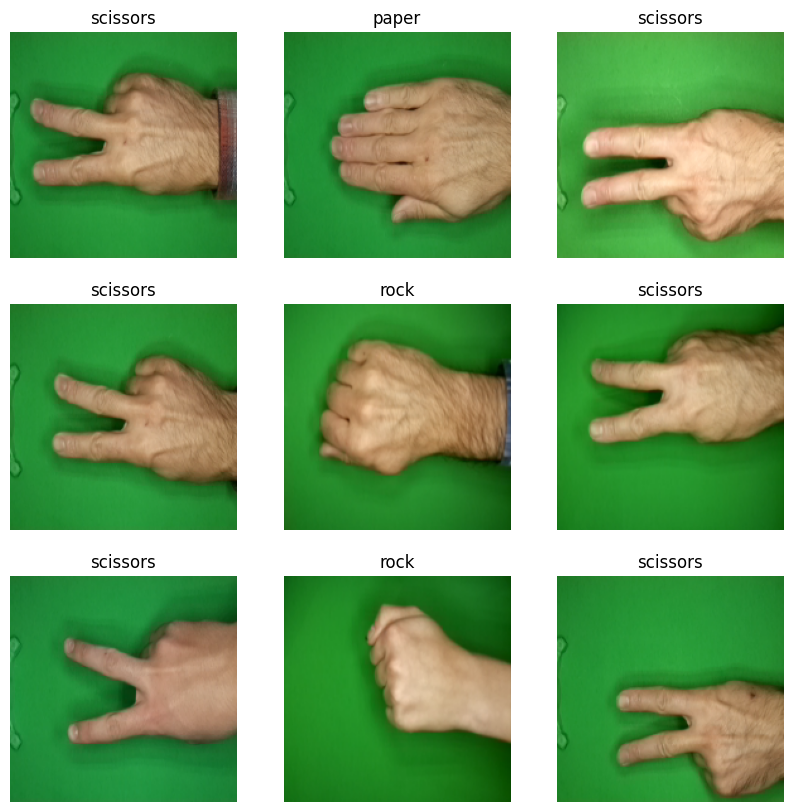

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Prefetched Yaklaşım -> zaman tasarrufu

okunan veriler eğitilirken bir sonraki grubu okuma işi de yapılır.

In [11]:
train_ds =train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds =train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


In [12]:
#ezberlemeden kurtulma, data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical", seed=42),
  tf.keras.layers.RandomRotation(0.1, seed=42),
])



katman inceleme -> [https://www.tensorflow.org/api_docs/python/tf](http://)

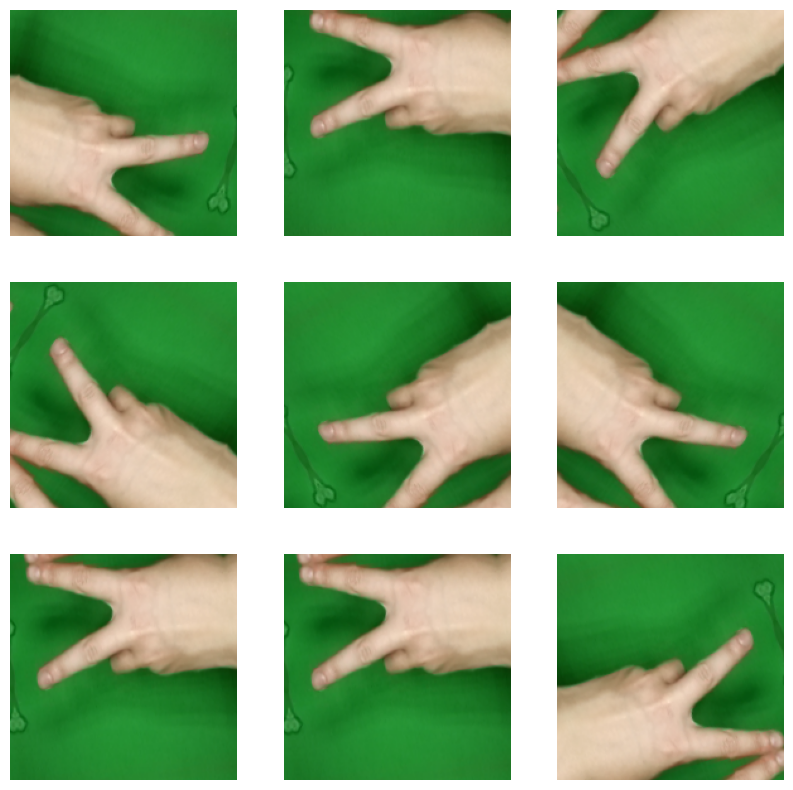

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# **Model Kurma**

In [14]:

model = tf.keras.Sequential([
    #0-1 aralığına getirme
    tf.keras.layers.Rescaling(1./255, input_shape=(180, 180, 3)),
    data_augmentation,
    # 1. cnn
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    #max havuzlama ile parametre azaltma
    tf.keras.layers.MaxPooling2D(),
    # 2. cnn
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    # 3. cnn
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    # 4. cnn
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    #filtreleri tek boyute indirgeme
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    
    tf.keras.layers.Dense(3)
])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 22, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     7,930,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,378,243 (31.96 MB)

 Trainable params: 8,378,243 (31.96 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
)

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - accuracy: 0.3649 - loss: 1.3857 - val_accuracy: 0.6362 - val_loss: 0.8996
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.6770 - loss: 0.7488 - val_accuracy: 0.9206 - val_loss: 0.2247
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.8781 - loss: 0.3343 - val_accuracy: 0.9206 - val_loss: 0.2299
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.8878 - loss: 0.3086 - val_accuracy: 0.9446 - val_loss: 0.1787
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.8982 - loss: 0.2762 - val_accuracy: 0.9429 - val_loss: 0.1448
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9224 - loss: 0.2184 - val_accuracy: 0.9549 - val_loss: 0.1317
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9386 - loss: 0.1713 - val_accuracy: 0.9760 - val_loss: 0.0797
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9449 - loss: 0.1486 - val_accuracy: 0

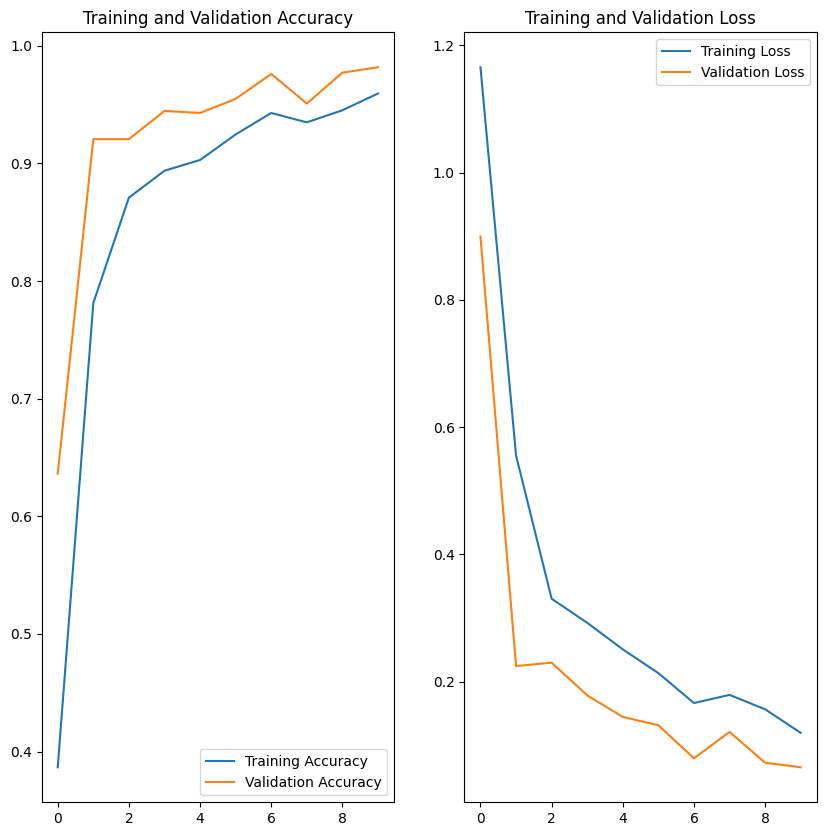

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
'/kaggle/input/tkm-data/kagit.jpg' resmi 'paper' 99.65%. olasılıkla 


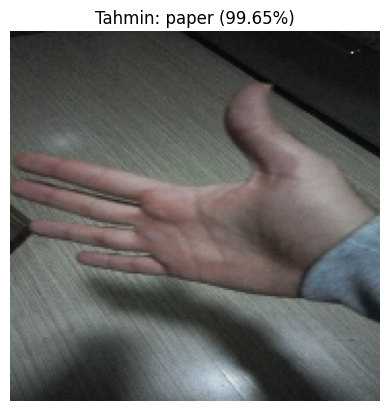

In [26]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


image_paths = ["/kaggle/input/tkm-data/kagit.jpg"] 
for image_path in image_paths:
    # Resmi yükleme ve ölçekleme
    img = tf.keras.utils.load_img(image_path, target_size=(180, 180))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Batch oluşturma

    # Tahmin
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

  
    predicted_class = class_names[np.argmax(score)]
    confidence = 100 * np.max(score)

    print(f"'{image_path}' resmi '{predicted_class}' {confidence:.2f}%. olasılıkla ")


    plt.figure()
    plt.imshow(img)
    plt.title(f"Tahmin: {predicted_class} ({confidence:.2f}%)")
    plt.axis("off")
    plt.show()
